Jianuo Liu, Rai Gohalwar

In [ ]:
# !pip uninstall numpy
# !pip install numpy==1.19.2


     |████████████████████████████████| 14.5MB 285kB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim.parsing import preprocessing
from gensim.parsing.preprocessing import STOPWORDS
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import random
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from gensim.models import LdaModel
from gensim.models import Word2Vec
from sklearn import svm
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
from __future__ import print_function
from gensim import corpora, models, similarities, matutils
import scipy
from gensim.models.coherencemodel import CoherenceModel
import codecs
import logging
from gensim.matutils import corpus2csc, corpus2dense

In [ ]:
class Partition:
    def __init__(self):
      nltk.download('gutenberg')
      nltk.download('punkt')
      nltk.download('stopwords')
      self.books = nltk.corpus.gutenberg.fileids()
      self.text = None
      self.words = None
      self.sentence = None
      self.chunks = []
      self.df = None
      self.label_list = []
      self.encoder_nums = LabelEncoder()

    # get the full text content of the book    
    def getRawBook(self, bookName:str):
      self.text = nltk.corpus.gutenberg.raw(bookName)
      author = self.getAuthor()
      self.text = self.text.lower()
      return author
    
    # remove the punctuation and stopwords, only keep the words with meaning
    # def tokenize(self, removePunc = False, removeStop = False):
    #   if self.text != None:
    #     if removePunc:
    #       #tokenizer = RegexpTokenizer(r'\w+')
    #       self.text = preprocessing.strip_punctuation(self.text)
    #     if removeStop:
    #       my_stop_words = STOPWORDS.union(set(['s', 'd', 't', 're']))
    #       self.text = preprocessing.remove_stopwords(self.text)
    #     self.words = nltk.word_tokenize(self.text)
    #   else:
    #     print("text is null, tokenize should be invoked after getRawBook.")

    def tokenize(self, removePunc = False, removeStop = False):
      if self.text != None:
          self.words = nltk.word_tokenize(self.text)
          if removeStop:
            en = spacy.load('en_core_web_sm')
            sw_spacy = en.Defaults.stop_words
            word_without_sw = [word for word in self.words if not word in sw_spacy]
            #print(type(word_without_sw))
            self.words = word_without_sw
            #print(word_without_sw)
            #self.text = " ".join(words)

          if removePunc:
              #tokenizer = RegexpTokenizer(r'\w+')
            #   word_clean = [word for word in self.words if not word.is_punct]
            #   self.words = word_clean
            text = ""
            for word in self.words:
                text += word
                text += " "
            #text = [" ".join(word) for word in self.words]
            print(text)
            word_without_punc = preprocessing.strip_punctuation(text)
            self.words = word_without_punc
            self.words = self.words.split()

            print(self.words)
                 
      else:
        print("text is null, tokenize should be invoked after getRawBook.")
           

    # extract the author from each book        
    def getAuthor(self):
        text = nltk.sent_tokenize(self.text)[0]
        regex = r"((?<= by).*?(?=[\d\]]+))"
        match = re.search(regex, text)
        author = None
        if(match != None):
            author = match.group().strip()
            print("if: " + author)
        else:
            regex = r"(?<=\[).*?(?=\])"
            match = re.search(regex, text)
            author = match.group().strip()
            print("else: " + author)   
        return author
    
    # chunk the words by 200 partitions and then randomly pick 150 words in each partition.
    # add author to the end of each 150 words record
    def chunkize(self, author):
      chunk = []
      label_list = []
      for i in range(200):
        randomStart = random.randint(0, len(self.words) - 150)
        words150 = self.words[randomStart:randomStart+150]
        # words100 = map(str.lower, words100)
            # words100.append(author)
        label_list.append(author)
        string = ' '.join(words150)
        self.chunks.append(string)
      #self.chunks.extend(chunk)
      self.label_list.extend(label_list)
    
    # replace the author name at the end with one-hot binary numbers or real number to be the label (groups from the same book will have the same label)
    def oneHotLabelWithSplit(self, oneHot=True):
      label_nums = self.encoder_nums.fit_transform(self.label_list)
      categories = list(self.encoder_nums.classes_)
      label_nums = np.array([label_nums]).T
      encoder_one_hot = OneHotEncoder()
      label_one_hot = encoder_one_hot.fit_transform(label_nums)
      label_one_hot = label_one_hot.toarray()
      print(np.array(self.chunks).shape, label_one_hot.shape, label_nums.shape)
      if not oneHot:
        return model_selection.train_test_split(self.chunks, label_nums, test_size=0.2, random_state=1024)
      else:
        return model_selection.train_test_split(self.chunks, label_one_hot, test_size=0.2, random_state=1024)

    def oneHotLabel(self, oneHot=True, shuffle=True):
        label_nums = self.encoder_nums.fit_transform(self.label_list)
        categories = list(self.encoder_nums.classes_)
        label_nums = np.array([label_nums]).T
        encoder_one_hot = OneHotEncoder()
        label_one_hot = encoder_one_hot.fit_transform(label_nums)
        label_one_hot = label_one_hot.toarray()
        print(np.array(self.chunks).shape, label_one_hot.shape, label_nums.shape)
        if shuffle:
            if not oneHot:
                dataset = np.hstack([np.array(self.chunks).reshape(1000,1), label_nums])
                np.random.seed(1024)
                np.random.shuffle(dataset)
                return dataset[:,:-1],dataset[:,-1].astype(np.int)
            else:
                dataset = np.hstack([np.array(self.chunks).reshape(1000,1), label_one_hot.astype(np.int)])
                np.random.seed(1024)
                np.random.shuffle(dataset)
                return dataset[:,:-5],dataset[:,-5:].astype(np.int)
        else:
            if not oneHot:
                return np.array(self.chunks), label_nums
            else:
                return np.array(self.chunks), label_one_hot 

    
    def buildDF(self):
      npChunks = np.array(self.chunks)
      print(npChunks.shape)
      data = npChunks.reshape((1000, 100))
      print(data.shape)
      self.df = pd.DataFrame(data)

In [ ]:
partition = Partition()
books = ['austen-sense.txt','whitman-leaves.txt','bible-kjv.txt','burgess-busterbrown.txt','shakespeare-hamlet.txt']

for book in books:
  print(book)
  author = partition.getRawBook(book)
  partition.tokenize(removePunc = True, removeStop = True)
  partition.chunkize(author)
#partition.buildDF()
#df = partition.df

X_train, X_test, y_train_onehot, y_test_onehot = partition.oneHotLabelWithSplit()
# #print(X_train[0:10])
X_train, X_test, y_train_num, y_test_num = partition.oneHotLabelWithSplit(oneHot=False)

#X, y_onehot = partition.oneHotLabel()
X, y_num = partition.oneHotLabel(oneHot=False, shuffle=True)


[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
austen-sense.txt
if: Jane Austen
[ sense sensibility jane austen 1811 ] chapter 1 family dashwood long settled sussex . estate large , residence norland park , centre property , , generations , lived respectable manner engage general good opinion surrounding acquaintance . late owner estate single man , lived advanced age , years life , constant companion housekeeper sister . death , happened years , produced great alteration home ; supply loss , invited received house family nephew mr. henry dashwood , legal inheritor norland estate , person intended bequeath . society nephew niece , children , old gentleman days comfortably spent . attachmen

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
class FeatureModel:
    def __init__(self, X_train, X_test):
      self.X_train = X_train
      self.X_test = X_test
      self.modelName = None
      self.freqMatrix = None
      self.bag = None
      self.X = None
      self.vec = None
      self.tfidf = None
      self.transformer = None
    
    def toBOW(self):
      self.vec = CountVectorizer()
      X_train_vec = self.vec.fit_transform(self.X_train)
      X_test_vec = self.vec.transform(self.X_test)
      return X_train_vec, X_test_vec
        
    def toTFIDF(self):
      self.vec = TfidfVectorizer(max_df=0.9)
      X_train_vec = self.vec.fit_transform(self.X_train)
      X_test_vec = self.vec.transform(self.X_test)
      return X_train_vec, X_test_vec
    
    def toNGram(self):
      self.vec = CountVectorizer(min_df = 1, ngram_range = (1,2))#, analyzer="char_wb")
      X_train_vec = self.vec.fit_transform(self.X_train)
      X_test_vec = self.vec.transform(self.X_test)
      return X_train_vec, X_test_vec



In [ ]:
class FeatureModel2:
    def __init__(self, X):
      self.X = X
      #self.X = [row[0].split() for row in X]
      self.modelName = None
      self.freqMatrix = None
      self.bag = None
      self.vec = None
      self.tfidf = None
      self.transformer = None

    def toBOW(self):
        self.vec = CountVectorizer()
        X_vec = self.vec.fit_transform(self.X.reshape((1000,))) # self.X (1000,)
        #X_vec = self.vec.fit_transform(np.array(self.X).reshape((1000,)))
        return X_vec

    def toTFIDF(self):
        self.vec = TfidfVectorizer(max_df=0.9)
        X_vec = self.vec.fit_transform(self.X.reshape((1000,))) # self.X (1000,)
        #X_vec = self.vec.fit_transform(np.array(self.X).reshape((1000,)))
        return X_vec

    def toPCA(self, X):
        pca = PCA(n_components=4)
        X_vec = pca.fit_transform(X)
        return X_vec

    
    # def toBOW(self):
    #     self.dictionary = corpora.Dictionary(self.X)
    #     self.corpus = [self.dictionary.doc2bow(doc) for doc in self.X]
    #     self.corpus_bow_dense = corpus2dense(self.corpus, len(self.dictionary.keys()), self.dictionary.num_docs)
    #     return self.corpus
        
    # def toTFIDF(self):
    #     self.toBOW()
    #     tfidf = models.TfidfModel(self.corpus)
    #     self.corpus_tfidf = tfidf[self.corpus]
    #     self.corpus_tfidf_dense = corpus2dense(self.corpus_tfidf, len(self.dictionary.keys()), self.dictionary.num_docs)
    #     return self.corpus_tfidf


    def toLDA(self, num_topics):
        # self.lda = LatentDirichletAllocation(n_components=n_components)
        # X_lda = self.lda.fit_transform(X.toarray())
        X_lda = [row[0].split() for row in self.X]
        self.dictionary = corpora.Dictionary(X_lda)
        self.corpus = [self.dictionary.doc2bow(doc) for doc in X_lda]
        tfidf = gensim.models.TfidfModel(self.corpus)
        self.corpus_tfidf = tfidf[self.corpus]
        self.lda_model = LdaModel(self.corpus, id2word=self.dictionary, num_topics=num_topics, random_state=1)
        corpus_lda = self.lda_model[self.corpus_tfidf]
        return corpus_lda

    def toLDA_sk(self, n_components):
        tfidf_vectorizer = TfidfVectorizer(max_df=0.9)
        dtm_tfidf = tfidf_vectorizer.fit_transform(self.X.reshape((1000,)))
        lda_tfidf = LatentDirichletAllocation(n_components=n_components, random_state=0)
        lda_tfidf.fit(dtm_tfidf)
        return lda_tfidf, dtm_tfidf, tfidf_vectorizer
    
    def toDoc2Vec(self):
        documents = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(self.X)]
        model = Doc2Vec(documents, size=len(self.X), window=2, min_count=1, workers=4, epochs=20)
        return model.infer_vector(self.X)

    def toWord2Vec(self):
        # [["str", "fafd", "fsdfdsf"]]  [["str fafd fsdfdsf"]]
        model = Word2Vec(sentences=[row[0].split() for row in self.X], size=100, window=2, min_count=1, workers=4)
        # #self.w2v.train(self.X_train, total_examples=len(self.X_train), epochs=20)
        # # return self.w2v.wv
        wv = []
        for x in self.X: # x : ["str fdsfasf fdsafds dfdfsad .."] 
            v = []
            for w in x[0].split(): # ["str", "fdsfa"...]
                v.append(model.wv[w])
            wv.append(v)
        return np.array(wv).reshape((1000, -1))




In [ ]:
# Feature Engineeing for Clustering
featureModel = FeatureModel2(X)
X_BOW = featureModel.toBOW()
print(X_BOW.shape)
X_BOW_DR = featureModel.toPCA(X_BOW.toarray())
print(X_BOW_DR.shape)
# print(X_BOW)

X_TFIDF = featureModel.toTFIDF()
X_TFIDF_DR = featureModel.toPCA(X_TFIDF.toarray())
print(X_TFIDF_DR.shape)
# print(X_TFIDF)

X_W2V = featureModel.toWord2Vec()
X_W2V_DR = featureModel.toPCA(X_W2V)
print(Word2Vec)
print(X_W2V.shape)
print(X_W2V_DR.shape)


(1000, 14955)
(1000, 4)
(1000, 4)
<class 'gensim.models.word2vec.Word2Vec'>
(1000, 15000)
(1000, 4)


In [ ]:
# Classification Champion
print(np.array(X_train).shape)
featureModel_Cla = FeatureModel(X_train, X_test)
X_train_TFIDF, X_test_TFIDF = featureModel_Cla.toTFIDF()
X_Cla_TFIDF = featureModel_Cla.vec.transform(X.reshape((1000,)))
print(X_train_TFIDF.shape)
print(X_Cla_TFIDF.shape)

(800,)
(800, 13726)
(1000, 13726)


In [ ]:
class Model:
    def __init__(self, traindata, trainlabel, modelName:str):
        self.x = traindata
        self.y = trainlabel.reshape((trainlabel.shape[0],))
        #print(self.x)
        #print(self.y)
        self.modelName = modelName
        self.kf = KFold(n_splits = 10)
        self.clf = None
        if self.modelName == 'DecisionTree':
          self.DecisionTree()
        elif self.modelName == 'SVM':
          self.SVM()
        elif self.modelName == 'KNN':
          self.KNN()
        
    
    def SVM(self):
        self.clf = svm.SVC(kernel="linear")
        scores = cross_val_score(self.clf, self.x, self.y, cv=10)
        print("scores:",scores)
        print("scores mean:", scores.mean())
        self.clf.fit(self.x, self.y)
    

    def DecisionTree(self):
        self.clf = tree.DecisionTreeClassifier()
        scores = cross_val_score(self.clf, self.x, self.y, cv=10)
        print("scores:",scores)
        print("scores mean:", scores.mean())
        self.clf.fit(self.x, self.y)         

    
    def KNN(self):
        self.clf = KNeighborsClassifier(n_neighbors=3)
        scores = cross_val_score(self.clf, self.x, self.y, cv=10)
        print("scores:",scores)
        print("scores mean:", scores.mean())
        self.clf.fit(self.x, self.y)

In [ ]:
# Get Predicted Labels from Classification Champion Model
model_TFIDF_SVM = Model(X_train_TFIDF.reshape((800,-1)).tocsr(), y_train_num.reshape((800,)), 'SVM')
predicted_SVM = model_TFIDF_SVM.clf.predict(X_Cla_TFIDF.tocsr())

scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
scores mean: 1.0


In [ ]:
class ClusterModel:

    def __init__(self, X):
        self.X = X
        self.hc = None

    def hierCluster(self):
        n = input("enter the optimal n_clusters:")
        self.hc = AgglomerativeClustering(n_clusters=int(n), affinity='euclidean', linkage='ward')
        y_hc = self.hc.fit_predict(self.X)
        #print(y_hc)

        plt.scatter(self.X[:,0], self.X[:,2], c=y_hc, cmap="rainbow")
        #plt.legend(loc='best',shadow=False,scatterpoints=1)
        plt.show()
        return y_hc

    def KMCluster(self):
        
        # kmc = KMeans(init='k-means++', n_clusters=k, n_init=10)
        sse = {}
        for k in range(2, 12):
           kmc = KMeans(n_clusters=k).fit(self.X)
           #data["clusters"] = kmc.labels_
           sse[k] = kmc.inertia_
        plt.figure()
        plt.plot(list(sse.keys()), list(sse.values()))
        plt.xlabel("Number of cluster")
        plt.ylabel("Distortion")
        plt.title('Elbow Method For Optimal k')

        plt.show()
        #kmc = KMeans(n_clusters=k)
        #kmc.fit(self.X)
        # y_kmc = kmc.fit_predict(self.X)
        #print(y_kmc)

        nn   = input("enter the optimal n: ")
        n = int(nn)
        kmc = KMeans(n_clusters=n).fit(self.X)
        y_kmc = kmc.fit_predict(self.X)
        centers = np.array(kmc.cluster_centers_)
        
        plt.scatter(self.X[:,0], self.X[:,1], c=y_kmc, cmap="rainbow")
        plt.scatter(centers[:,0], centers[:,1], marker="x", color='black')
        plt.show()
        return y_kmc

    def EMCluster(self):
        nn   = input("enter the optimal n: ")
        n = int(nn)
        gmm = GaussianMixture(n_components=n)
        gmm.fit(self.X)

        labels = gmm.predict(self.X)
        plt.scatter(self.X[:, 0], self.X[:, 1], c=labels, cmap='Spectral');
        return labels

In [ ]:
#silhouette score initialization
silhouette_score = {}

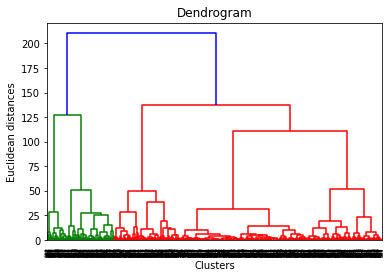

In [ ]:
# Find the optimal number of clusters for AC / BOW
dendrogram = sch.dendrogram(sch.linkage(X_BOW_DR, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distances')
plt.show() 

# optimal n_clusters = 5

enter the optimal n_clusters:5


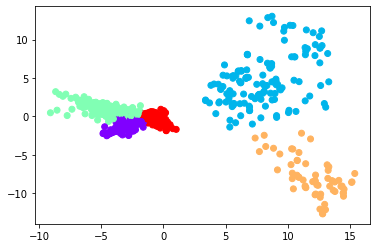

In [ ]:
# Optimal n_clusters = 5
cm = ClusterModel(X_BOW_DR)
y_hc_BOW = cm.hierCluster()

# print(y_num)
# print(y_hc)

silhouette_score["heir_BOW"] = metrics.silhouette_score(X_BOW_DR, y_hc_BOW, metric='euclidean')

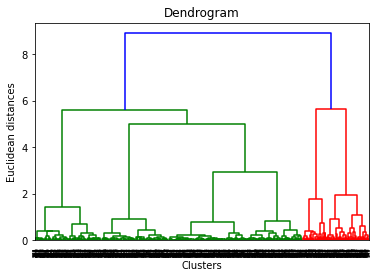

In [ ]:
# Find the optimal number of clusters for AC / TFIDF
dendrogram = sch.dendrogram(sch.linkage(X_TFIDF_DR, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distances')
plt.show() 

# optimal n_clusters = 2

enter the optimal n_clusters:2


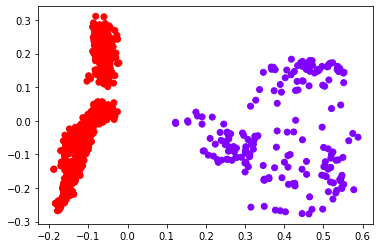

In [ ]:
# Optimal n_clusters = 2
cm = ClusterModel(X_TFIDF_DR)
y_hc_TFIDF = cm.hierCluster()

# print(y_num)
# print(y_hc)

silhouette_score["heir_TFIDF"] = metrics.silhouette_score(X_TFIDF_DR, y_hc_TFIDF, metric='euclidean')

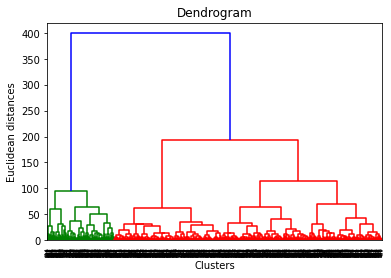

In [ ]:
# Find the optimal number of clusters for AC / W2V
dendrogram = sch.dendrogram(sch.linkage(X_W2V_DR, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distances')
plt.show() 

# optimal n_clusters = 2

enter the optimal n_clusters:2


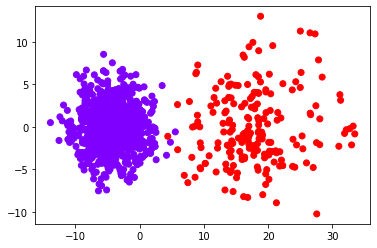

In [ ]:
# Optimal n_clusters = 2
cm = ClusterModel(X_W2V_DR)
y_hc_W2V = cm.hierCluster()

# print(y_num)
# print(y_hc)

silhouette_score["heir_W2V"] =metrics.silhouette_score(X_W2V_DR, y_hc_W2V, metric='euclidean')

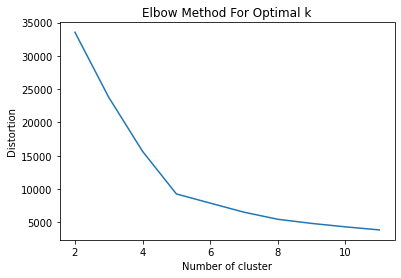

enter the optimal n: 5


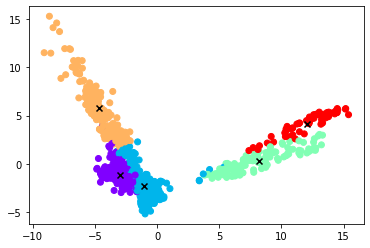

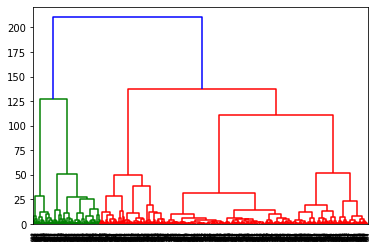

In [ ]:
kms = ClusterModel(X_BOW_DR)

# Optimal number = 5

y_kms_BOW = kms.KMCluster()
#print(y_kms)
dendrogram = sch.dendrogram(sch.linkage(X_BOW_DR, method='ward'))
silhouette_score["kms_BOW"] =metrics.silhouette_score(X_BOW_DR, y_kms_BOW, metric='euclidean')

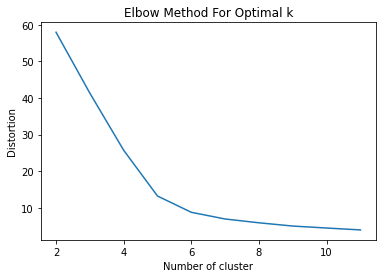

enter the optimal n: 5


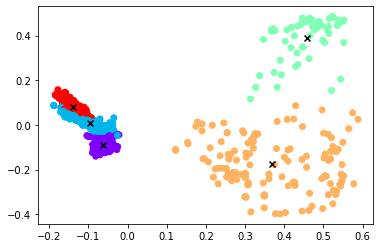

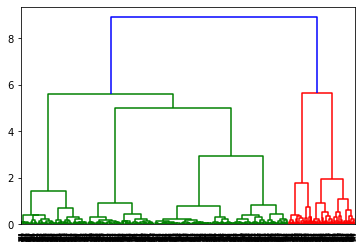

In [ ]:
kms = ClusterModel(X_TFIDF_DR)

# Optimal number = 5

y_kms_TFIDF = kms.KMCluster()

dendrogram = sch.dendrogram(sch.linkage(X_TFIDF_DR, method='ward'))
silhouette_score["kms_TFIDF"] =metrics.silhouette_score(X_TFIDF_DR, y_kms_TFIDF, metric='euclidean')

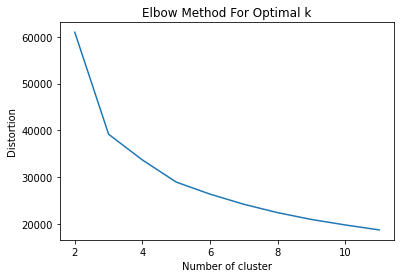

enter the optimal n: 3


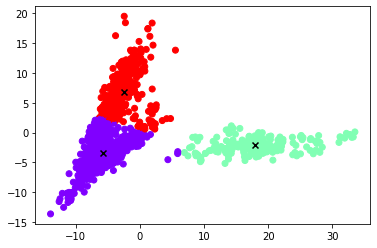

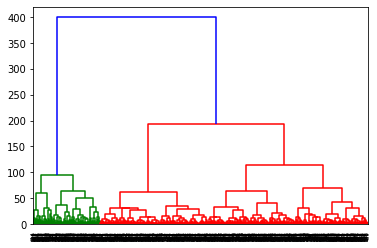

In [ ]:
kms = ClusterModel(X_W2V_DR)

# Optimal number = 3

y_kms_W2V = kms.KMCluster()

dendrogram = sch.dendrogram(sch.linkage(X_W2V_DR, method='ward'))
silhouette_score["kms_W2V"] = metrics.silhouette_score(X_W2V_DR, y_kms_W2V, metric='euclidean')

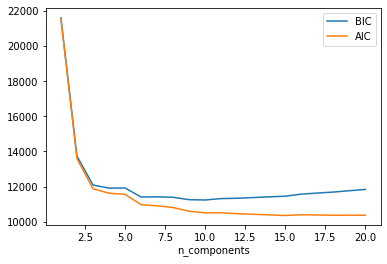

enter the optimal n: 5


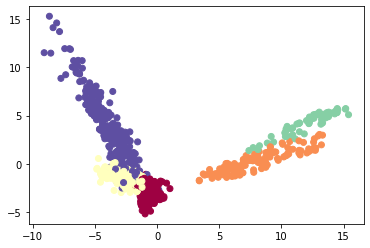

In [ ]:
 # EM Clustering W/ BOW
 n_components = np.arange(1,21)
 models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_BOW_DR) for n in n_components]
 plt.plot(n_components, [m.bic(X_BOW_DR) for m in models], label='BIC')
 plt.plot(n_components, [m.aic(X_BOW_DR) for m in models], label='AIC')
 plt.legend(loc='best')
 plt.xlabel('n_components')
 plt.show()
 em = ClusterModel(X_BOW_DR)
 y_em_BOW = em.EMCluster()
 silhouette_score["EM_BOW"] =metrics.silhouette_score(X_BOW_DR, y_em_BOW, metric='euclidean')

 # Optimal number = 5

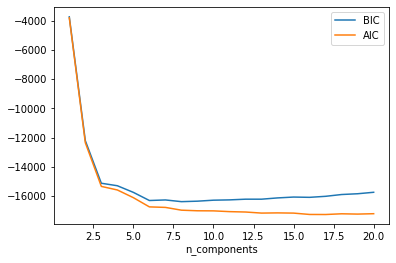

enter the optimal n: 5


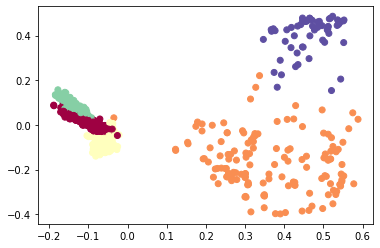

In [ ]:
 # EM Clustering W/ TFIDF
 n_components = np.arange(1,21)
 models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_TFIDF_DR) for n in n_components]
 plt.plot(n_components, [m.bic(X_TFIDF_DR) for m in models], label='BIC')
 plt.plot(n_components, [m.aic(X_TFIDF_DR) for m in models], label='AIC')
 plt.legend(loc='best')
 plt.xlabel('n_components')
 plt.show()
 em = ClusterModel(X_TFIDF_DR)
 y_em_TFIDF = em.EMCluster()
 silhouette_score["EM_TFIDF"] = metrics.silhouette_score(X_TFIDF_DR, y_em_TFIDF, metric='euclidean')
 # Optimal number = 5

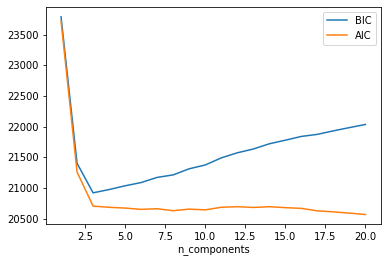

enter the optimal n: 3


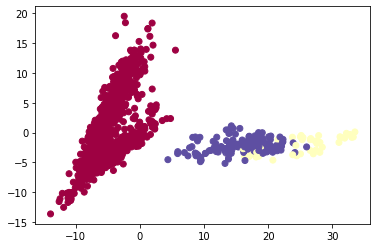

In [ ]:
 # EM Clustering W/ W2V
 n_components = np.arange(1,21)
 models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_W2V_DR) for n in n_components]
 plt.plot(n_components, [m.bic(X_W2V_DR) for m in models], label='BIC')
 plt.plot(n_components, [m.aic(X_W2V_DR) for m in models], label='AIC')
 plt.legend(loc='best')
 plt.xlabel('n_components')
 plt.show()
 em = ClusterModel(X_W2V_DR)
 y_em_W2V = em.EMCluster()
 silhouette_score["EM_W2V"] = metrics.silhouette_score(X_W2V_DR, y_em_W2V, metric='euclidean')
 # Optimal number = 3

In [ ]:
# Kappa Score

# Compare Predicted labels from Classification Champion and that of Clustering
print(cohen_kappa_score(y_hc_BOW, predicted_SVM))
print(cohen_kappa_score(y_hc_TFIDF, predicted_SVM))
print(cohen_kappa_score(y_hc_W2V, predicted_SVM))
print(cohen_kappa_score(y_kms_BOW, predicted_SVM))
print(cohen_kappa_score(y_kms_TFIDF, predicted_SVM))
print(cohen_kappa_score(y_kms_W2V, predicted_SVM))
print(cohen_kappa_score(y_em_BOW, predicted_SVM))
print(cohen_kappa_score(y_em_TFIDF, predicted_SVM))
print(cohen_kappa_score(y_em_W2V, predicted_SVM))


-0.24750000000000005
0.0
0.0
0.06999999999999995
0.0
-0.02499999999999991
0.12749999999999995
0.31999999999999995
0.0


In [ ]:
# Kappa Score / Compare Predicted Labels from Different Cluters
print(cohen_kappa_score(y_hc_TFIDF, y_kms_TFIDF))
print(cohen_kappa_score(y_hc_BOW, y_kms_BOW))
print(cohen_kappa_score(y_hc_W2V, y_kms_W2V))
print(cohen_kappa_score(y_hc_TFIDF, y_em_TFIDF))
print(cohen_kappa_score(y_hc_BOW, y_em_BOW))
print(cohen_kappa_score(y_hc_W2V, y_em_W2V))
print(cohen_kappa_score(y_em_TFIDF, y_kms_TFIDF))
print(cohen_kappa_score(y_em_BOW, y_kms_BOW))
print(cohen_kappa_score(y_em_W2V, y_kms_W2V))

0.27368421052631575
-0.029302316705469345
0.4477982954545455
-0.02092904543134244
0.10986077865502264
0.3389281507656067
-0.2136689004329846
-0.15051329208761177
0.7070207090098841


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

1 -3.7370205622576935


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

2 -3.31537501604976


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

3 -3.7620306225288807


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

4 -3.532640033537122


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

5 -3.4715037133266136


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

6 -3.1567884654767173


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

7 -3.1913199287309655


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

8 -2.953259798257301


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

9 -3.159095988941243


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

10 -3.3583908289065563


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

11 -3.10725971500981


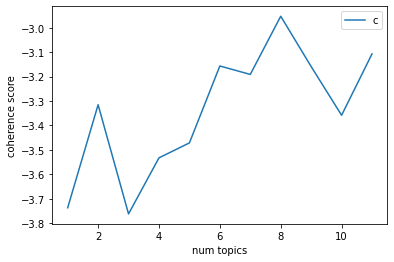

In [ ]:
#Coherence Test
featureModel = FeatureModel2(X)

featureModel.toTFIDF()
x_list = []
y_list = []
for i in range(1, 12):
    lda = featureModel.toLDA(num_topics=i)
    cv_tmp = CoherenceModel(model=featureModel.lda_model, corpus=featureModel.corpus, coherence='u_mass')
    x_list.append(i)
    print(i, cv_tmp.get_coherence())
    y_list.append(cv_tmp.get_coherence())
plt.plot(x_list, y_list)
plt.xlabel('num topics')
plt.ylabel('coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()




In [ ]:
# LDA Visualization
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# number of topics = 7

lda_tfidf, dtm_tfidf, tfidf_vectorizer = FeatureModel2(X).toLDA_sk(7)

pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.093094  0.074923       1        1  49.619531
3     -0.058429 -0.095447       2        1  19.679238
2      0.058033  0.026447       3        1  15.542152
1      0.029186 -0.000056       4        1   5.119955
0      0.026066 -0.002900       5        1   4.421866
5      0.021344 -0.002100       6        1   3.266677
6      0.016894 -0.000868       7        1   2.350581, topic_info=         Term       Freq      Total Category  logprob  loglift
1882   buster  18.000000  18.000000  Default  30.0000  30.0000
7806   little  17.000000  17.000000  Default  29.0000  29.0000
7278      joe  11.000000  11.000000  Default  28.0000  28.0000
1196     bear  12.000000  12.000000  Default  27.0000  27.0000
6010      ham  10.000000  10.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
11126    rowe   0.040667   0.338271   Topic7  -8.5652   1.6321
5064     fiue   0.040667   0.338271   Topic7  -8.5652   1.6321
12945   sword   0.050273   2.405527   Topic7  -8.3532  -0.1175
232     actor   0.041328   0.425819   Topic7  -8.5491   1.4180
12991    tale   0.041131   0.538215   Topic7  -8.5539   1.1790

[357 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
0          1  0.991876          10
2          1  0.860094          11
7          1  1.021230          13
11         1  1.039071          16
13         1  1.014647          18
...      ...       ...         ...
14305      3  0.994110          vs
14443      1  0.462087         way
14443      2  0.616116         way
14638      1  1.015826  willoughby
14874      1  0.940503          ye

[199 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 1, 6, 7])

In [ ]:
# t = input("enter the optimized number of topics:")
# featureModel.toLDA(num_topics=t)
# featureModel.lda_model.print_topics(int(t))

enter the optimized number of topics:7


[(0,
  '0.007*"said" + 0.006*"elinor" + 0.006*"little" + 0.005*"thou" + 0.005*"lord" + 0.005*"unto" + 0.005*"shall" + 0.004*"marianne" + 0.004*"mrs" + 0.004*"time"'),
 (1,
  '0.012*"shall" + 0.007*"little" + 0.007*"buster" + 0.007*"lord" + 0.005*"ham" + 0.005*"said" + 0.004*"know" + 0.004*"bear" + 0.004*"unto" + 0.003*"fish"'),
 (2,
  '0.009*"unto" + 0.008*"son" + 0.007*"shall" + 0.005*"lord" + 0.005*"ye" + 0.005*"old" + 0.005*"man" + 0.004*"thee" + 0.004*"thy" + 0.004*"come"'),
 (3,
  '0.012*"shall" + 0.005*"man" + 0.005*"unto" + 0.005*"lord" + 0.005*"know" + 0.004*"said" + 0.004*"ham" + 0.004*"king" + 0.004*"10" + 0.004*"time"'),
 (4,
  '0.010*"shall" + 0.010*"buster" + 0.008*"lord" + 0.007*"little" + 0.007*"thy" + 0.006*"bear" + 0.005*"thee" + 0.005*"thou" + 0.005*"o" + 0.005*"come"'),
 (5,
  '0.014*"little" + 0.010*"buster" + 0.009*"lord" + 0.009*"said" + 0.009*"joe" + 0.008*"bear" + 0.006*"know" + 0.006*"thou" + 0.005*"shall" + 0.005*"ham"'),
 (6,
  '0.006*"thy" + 0.006*"shall" + 

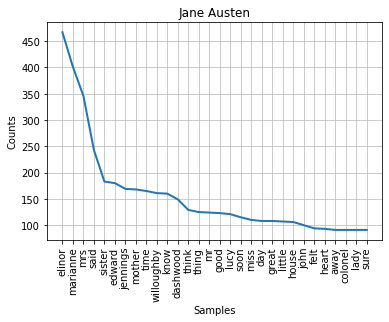

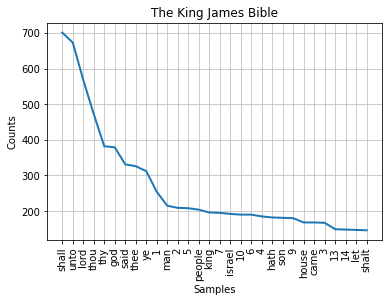

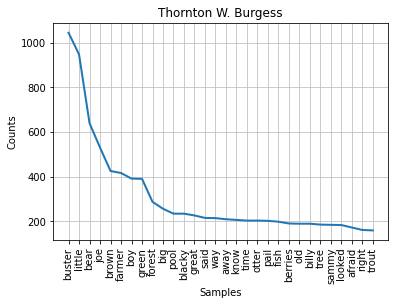

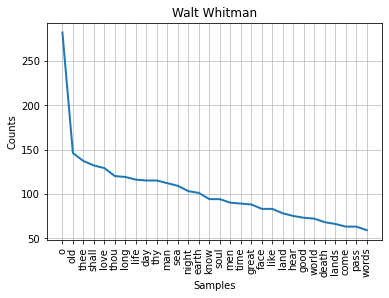

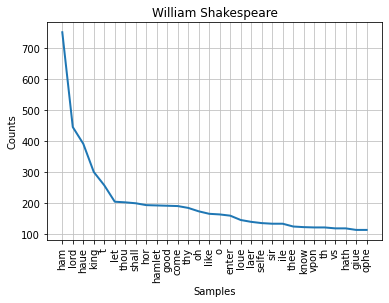

In [ ]:
# visualizing the words frequency of each book after cleansing
authors = list(partition.encoder_nums.classes_)

fdist = []
fdist.append([])
fdist.append([])
fdist.append([])
fdist.append([])
fdist.append([])

from nltk.probability import FreqDist
import matplotlib.pyplot as plt
index = 0

for i in range(len(X)):
  index = y_num[i]
  fdist[index].append(X[i][0])

for i in range(5):
  fdist[i] = " ".join(fdist[i])
  fdist[i] = fdist[i].split(" ")

  fdistt = FreqDist(fdist[i])  

  plt.title(authors[i])
  plt.xlabel("Word")
  plt.ylabel("Frequency")
  fdistt.plot(30,cumulative=False)


  plt.show()



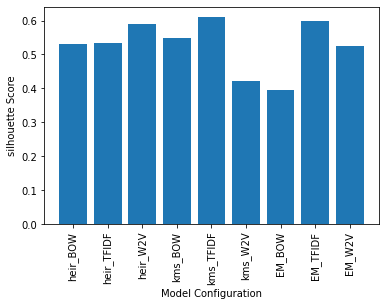

In [ ]:
plt.bar(*zip(*silhouette_score.items()))
plt.xticks(rotation=90)
plt.xlabel("Model Configuration")
plt.ylabel("silhouette Score")


plt.show()